In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [3]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_9slgdf5
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_9slgdf5/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_9slgdf5/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,29 days
H2O cluster name:,H2O_from_python_phall_oevqha
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [4]:
# load clean data
path = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}

In [6]:
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
frame.describe() # summarize data

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456332,,13.715904065566189,5.684352932995338,,71915.67051974905,,,15.881530121290167,0.22735700606252723,54.07917280242262,24.579733834274574,,14.854273655448333,
maxs,35000.0,,26.060000000000002,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734672,,4.391939870545809,3.610663731100238,,59070.91565491818,,,7.5876682241925355,0.6941679229284191,25.285366766770498,11.685190365910666,,6.947732922546689,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.650000000000002,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

In [9]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

bad_loan
['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']


In [10]:
# determine column types
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)

print(enums)
print(reals)

['addr_state', 'term', 'purpose', 'home_ownership', 'verification_status']
['dti', 'loan_amnt', 'total_acc', 'revol_util', 'emp_length', 'annual_inc', 'delinq_2yrs', 'int_rate', 'longest_credit_length']


In [11]:
# impute missing values
_ = frame[reals].impute(method='mean')

In [12]:
# set target to factor - for binary classification
# just to be safe ...
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [13]:
# neural network

# initialize nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio=0.2,      # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios=[0.05], # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation='TanhWithDropout', # bounded activation function that allows for dropout, tanh
    l1=0.001,                     # L1 penalty can help generalization   
    l2=0.01,                      # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=5,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model')          # for easy lookup in flow

# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
nn_model

# view detailed results at http://localhost:54321/flow/index.html

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  nn_model


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.13726220105689477
RMSE: 0.3704891375693689
LogLoss: 0.4370756865457397
Mean Per-Class Error: 0.3535416684525945
AUC: 0.6936333270332602
Gini: 0.3872666540665204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1590477876705046: 


,0,1,Error,Rate
0,5140.0,3053.0,0.3726,(3053.0/8193.0)
1,600.0,1194.0,0.3344,(600.0/1794.0)
Total,5740.0,4247.0,0.3658,(3653.0/9987.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1590478,0.3952988,262.0
max f2,0.1059466,0.5582335,326.0
max f0point5,0.2206463,0.3480028,201.0
max accuracy,0.4967869,0.8217683,26.0
max precision,0.5763859,0.6,3.0
max recall,0.0472462,1.0,397.0
max specificity,0.6152552,0.9998779,0.0
max absolute_mcc,0.1906367,0.2290269,228.0
max min_per_class_accuracy,0.1633571,0.6438127,257.0
max mean_per_class_accuracy,0.1590478,0.6464583,262.0


Gains/Lift Table: Avg response rate: 17.96 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100130,0.4949650,3.1731271,3.1731271,0.57,0.57,0.0317726,0.0317726,217.3127090,217.3127090
,2,0.0200260,0.4580062,2.3937625,2.7834448,0.43,0.5,0.0239688,0.0557414,139.3762542,178.3444816
,3,0.0300391,0.4353030,1.8370736,2.4679877,0.33,0.4433333,0.0183946,0.0741360,83.7073579,146.7987737
,4,0.0400521,0.4145941,2.8391137,2.5607692,0.51,0.46,0.0284281,0.1025641,183.9113712,156.0769231
,5,0.0500651,0.3977234,1.7814047,2.4048963,0.32,0.432,0.0178372,0.1204013,78.1404682,140.4896321
,6,0.1000300,0.3280945,1.8965355,2.1509704,0.3406814,0.3863864,0.0947603,0.2151616,89.6535546,115.0970368
,7,0.1499950,0.2804690,1.5618528,1.9547289,0.2805611,0.3511348,0.0780379,0.2931996,56.1852803,95.4728936
,8,0.2000601,0.2441262,1.6812007,1.8862784,0.302,0.3388388,0.0841695,0.3773690,68.1200669,88.6278419
,9,0.2999900,0.1971468,1.4279797,1.7336142,0.2565130,0.3114152,0.1426979,0.5200669,42.7979705,73.3614161
,10,0.4000200,0.1649253,1.1312098,1.5829754,0.2032032,0.2843554,0.1131550,0.6332219,13.1209805,58.2975375




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1376869934004904
RMSE: 0.3710619805376056
LogLoss: 0.4379198829084778
Mean Per-Class Error: 0.3534463552679302
AUC: 0.6986077275726538
Gini: 0.39721545514530754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17079314843567872: 


,0,1,Error,Rate
0,27130.0,13234.0,0.3279,(13234.0/40364.0)
1,3411.0,5571.0,0.3798,(3411.0/8982.0)
Total,30541.0,18805.0,0.3373,(16645.0/49346.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1707931,0.4009789,247.0
max f2,0.1125146,0.5593188,316.0
max f0point5,0.2687035,0.3660425,159.0
max accuracy,0.5386495,0.8185061,12.0
max precision,0.6166139,1.0,0.0
max recall,0.0415721,1.0,399.0
max specificity,0.6166139,1.0,0.0
max absolute_mcc,0.2140907,0.2333419,203.0
max min_per_class_accuracy,0.1637622,0.6448320,255.0
max mean_per_class_accuracy,0.1689692,0.6465536,249.0


Gains/Lift Table: Avg response rate: 18.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100109,0.4910842,2.8359080,2.8359080,0.5161943,0.5161943,0.0283901,0.0283901,183.5907983,183.5907983
,2,0.0200016,0.4604492,2.4516285,2.6439629,0.4462475,0.4812563,0.0244934,0.0528835,145.1628522,164.3962923
,3,0.0300126,0.4358523,2.2798476,2.5225092,0.4149798,0.4591492,0.0228234,0.0757070,127.9847594,152.2509194
,4,0.0400032,0.4146525,2.4627723,2.5075901,0.4482759,0.4564336,0.0246048,0.1003117,146.2772288,150.7590099
,5,0.0500142,0.3976686,2.3354536,2.4731349,0.4251012,0.4501621,0.0233801,0.1236918,133.5453633,147.3134907
,6,0.1000081,0.3249227,1.9641667,2.2187024,0.3575193,0.4038501,0.0981964,0.2218882,96.4166680,121.8702360
,7,0.1500020,0.2784483,1.7949188,2.0774602,0.3267126,0.3781410,0.0897350,0.3116232,79.4918757,107.7460243
,8,0.2000162,0.2440977,1.5982996,1.9576458,0.2909238,0.3563323,0.0799377,0.3915609,59.8299607,95.7645811
,9,0.3000041,0.1967167,1.3228061,1.7460612,0.2407783,0.3178195,0.1322645,0.5238254,32.2806131,74.6061173
,10,0.4000122,0.1654110,1.1577774,1.5989828,0.2107396,0.2910482,0.1157871,0.6396126,15.7777448,59.8982791



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-07-06 17:31:06,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-07-06 17:31:09,3.294 sec,69672 obs/sec,1.5304249,1,100050.0,0.3720781,0.4396404,0.6898352,2.8947826,0.3302293,0.3721194,0.4396922,0.6951212,2.6690899,0.3196814
,2017-07-06 17:31:11,4.997 sec,73710 obs/sec,3.0612170,2,200124.0,0.3724915,0.4426069,0.6909704,3.1174582,0.3146090,0.3742821,0.4458793,0.6924385,2.8025444,0.3079277
,2017-07-06 17:31:12,6.506 sec,77125 obs/sec,4.5916113,3,300172.0,0.3715599,0.4396212,0.6929769,2.9504515,0.3340342,0.3720627,0.4402496,0.6986440,2.7803019,0.3349410
,2017-07-06 17:31:15,9.756 sec,70280 obs/sec,6.1213326,4,400176.0,0.3757477,0.4520945,0.6885250,2.9504515,0.3528587,0.3771811,0.4545032,0.6928438,2.7246959,0.3162364
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2017-07-06 17:31:42,36.525 sec,77746 obs/sec,32.1311531,21,2100542.0,0.3727413,0.4429178,0.6902204,2.7834448,0.3113047,0.3730032,0.4433122,0.6962201,2.7914232,0.3219309
,2017-07-06 17:31:44,38.092 sec,77855 obs/sec,33.6650809,22,2200821.0,0.3708046,0.4382515,0.6919762,3.2844649,0.3205167,0.3719537,0.4401377,0.6957829,2.9359989,0.3176752
,2017-07-06 17:31:46,39.654 sec,77942 obs/sec,35.1928595,23,2300698.0,0.3711444,0.4386998,0.6889364,3.1174582,0.3523581,0.3719498,0.4400195,0.6928548,2.6802111,0.3368459
,2017-07-06 17:31:47,41.263 sec,77951 obs/sec,36.7198733,24,2400525.0,0.3752984,0.4506241,0.6926611,3.2844649,0.3158106,0.3759548,0.4517770,0.6965470,2.7914232,0.3349208



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
purpose.small_business,1.0,1.0,0.0478510
addr_state.WV,0.7957225,0.7957225,0.0380761
addr_state.DC,0.7101347,0.7101347,0.0339806
addr_state.MT,0.6937076,0.6937076,0.0331946
int_rate,0.6142963,0.6142963,0.0293947
---,---,---,---
addr_state.missing(NA),0.0,0.0,0.0
purpose.missing(NA),0.0,0.0,0.0
home_ownership.missing(NA),0.0,0.0,0.0
term.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [14]:
# measure nn AUC
print(nn_model.auc(train=True))
print(nn_model.auc(valid=True))
print(nn_model.model_performance(test_data=test).auc())

0.6936333270332602
0.6986077275726538
0.6910466932655376


In [15]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

# view detailed results at http://ip:port/flow/index.html

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [16]:
# show grid search results
gsearch.show()

# select best model
nn_model2 = gsearch.get_grid()[0]

# print model information
nn_model2

                hidden input_dropout_ratio    l1     l2  \
0     [50, 50, 50, 50]                 0.0   0.0  0.009   
1                [100]                0.02  0.02  0.003   
2     [50, 50, 50, 50]                 0.1  0.02  0.002   
3                [100]                0.14  0.04  0.009   
4       [320, 160, 80]                0.18  0.06  0.008   
5       [320, 160, 80]                0.12  0.06  0.005   
6       [320, 160, 80]                0.06  0.03  0.005   
7            [80, 190]                0.18  0.05  0.002   
8       [320, 160, 80]                0.06  0.08  0.004   
9     [50, 50, 50, 50]                0.08  0.04  0.004   
10    [50, 50, 50, 50]                0.02  0.06  0.004   
11    [50, 50, 50, 50]                0.14  0.03    0.0   
12           [80, 190]                0.02  0.07    0.0   
13           [80, 190]                0.18  0.05  0.003   
14           [80, 190]                 0.0  0.05  0.004   
15          [170, 320]                0.06  0.09  0.001 

,0,1,Error,Rate
0,5041.0,3054.0,0.3773,(3054.0/8095.0)
1,601.0,1244.0,0.3257,(601.0/1845.0)
Total,5642.0,4298.0,0.3677,(3655.0/9940.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1912002,0.4050138,202.0
max f2,0.0929216,0.5706448,311.0
max f0point5,0.3410043,0.3656546,77.0
max accuracy,0.4245313,0.8163984,2.0
max precision,0.4255959,0.5701754,1.0
max recall,0.0209484,1.0,390.0
max specificity,0.4262851,0.9970352,0.0
max absolute_mcc,0.1654997,0.2338504,229.0
max min_per_class_accuracy,0.2008647,0.6427424,193.0
max mean_per_class_accuracy,0.1654997,0.6503688,229.0


Gains/Lift Table: Avg response rate: 18.56 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100604,0.4254772,3.1247696,3.1247696,0.58,0.58,0.0314363,0.0314363,212.4769648,212.4769648
,2,0.0200201,0.4227846,2.5032986,2.8155956,0.4646465,0.5226131,0.0249322,0.0563686,150.3298568,181.5595593
,3,0.0300805,0.4202108,2.0472629,2.5586281,0.38,0.4749164,0.0205962,0.0769648,104.7262873,155.8628128
,4,0.0400402,0.4175355,2.3944595,2.5177922,0.4444444,0.4673367,0.0238482,0.1008130,139.4459500,151.7792213
,5,0.05,0.4146446,2.0679423,2.4281843,0.3838384,0.4507042,0.0205962,0.1214092,106.7942296,142.8184282
,6,0.1,0.3988114,1.9945799,2.2113821,0.3702213,0.4104628,0.0997290,0.2211382,99.4579946,121.1382114
,7,0.15,0.3666512,1.6260163,2.0162602,0.3018109,0.3742455,0.0813008,0.3024390,62.6016260,101.6260163
,8,0.2,0.3288440,1.6802168,1.9322493,0.3118712,0.3586519,0.0840108,0.3864499,68.0216802,93.2249322
,9,0.3,0.2592265,1.3387534,1.7344173,0.2484909,0.3219316,0.1338753,0.5203252,33.8753388,73.4417344
,10,0.4,0.2055017,1.1273713,1.5826558,0.2092555,0.2937626,0.1127371,0.6330623,12.7371274,58.2655827




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.13839502352355335
RMSE: 0.37201481626885957
LogLoss: 0.43960895517572524
Mean Per-Class Error: 0.3546866026396488
AUC: 0.6972734654391199
Gini: 0.3945469308782399
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2186940042193634: 


,0,1,Error,Rate
0,27573.0,12791.0,0.3169,(12791.0/40364.0)
1,3540.0,5442.0,0.3941,(3540.0/8982.0)
Total,31113.0,18233.0,0.3309,(16331.0/49346.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2186940,0.3999265,178.0
max f2,0.1124487,0.5596831,288.0
max f0point5,0.3397501,0.3640428,75.0
max accuracy,0.4256849,0.8183845,1.0
max precision,0.4264541,0.6117647,0.0
max recall,0.0006723,1.0,399.0
max specificity,0.4264541,0.9991824,0.0
max absolute_mcc,0.2454506,0.2322913,153.0
max min_per_class_accuracy,0.2006461,0.6446091,194.0
max mean_per_class_accuracy,0.1951939,0.6453134,200.0


Gains/Lift Table: Avg response rate: 18.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100109,0.4250747,2.9137564,2.9137564,0.5303644,0.5303644,0.0291695,0.0291695,191.3756438,191.3756438
,2,0.0200016,0.4220259,2.3847659,2.6495292,0.4340771,0.4822695,0.0238254,0.0529949,138.4765926,164.9529161
,3,0.0300126,0.4193939,2.2798476,2.5262188,0.4149798,0.4598244,0.0228234,0.0758183,127.9847594,152.6218767
,4,0.0400032,0.4166768,2.2510407,2.4574940,0.4097363,0.4473151,0.0224894,0.0983077,125.1040734,145.7493959
,5,0.0500142,0.4141412,2.1130295,2.3885452,0.3846154,0.4347650,0.0211534,0.1194611,111.3029478,138.8545234
,6,0.1000081,0.3925712,1.9753014,2.1819652,0.3595460,0.3971631,0.0987531,0.2182142,97.5301411,118.1965191
,7,0.1500020,0.3615394,1.8661810,2.0767180,0.3396838,0.3780059,0.0932977,0.3115119,86.6181040,107.6718028
,8,0.2000162,0.3231408,1.5760392,1.9515229,0.2868720,0.3552178,0.0788243,0.3903362,57.6039166,95.1522949
,9,0.3000041,0.2552185,1.3328274,1.7453190,0.2426024,0.3176844,0.1332665,0.5236028,33.2827390,74.5318958
,10,0.4000122,0.2037680,1.1310595,1.5917463,0.2058764,0.2897310,0.1131151,0.6367179,13.1059507,59.1746315



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-07-06 17:33:13,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-07-06 17:33:14,1 min 25.850 sec,65113 obs/sec,1.0,1,65374.0,0.3742152,0.4421454,0.7018378,3.1247696,0.3677062,0.3720148,0.4396090,0.6972735,2.9137564,0.3309488
,2017-07-06 17:33:19,1 min 30.482 sec,122837 obs/sec,10.0,10,653740.0,0.3788216,0.4540224,0.7030458,3.1247696,0.3250503,0.3761411,0.4502070,0.6975623,2.8136656,0.3261865
,2017-07-06 17:33:19,1 min 30.793 sec,122791 obs/sec,10.0,10,653740.0,0.3742152,0.4421454,0.7018378,3.1247696,0.3677062,0.3720148,0.4396090,0.6972735,2.9137564,0.3309488


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
home_ownership.NONE,1.0,1.0,0.0173319
addr_state.AK,0.9781761,0.9781761,0.0169537
addr_state.SD,0.9561462,0.9561462,0.0165719
addr_state.MO,0.9485161,0.9485161,0.0164396
addr_state.OK,0.9468167,0.9468167,0.0164102
---,---,---,---
addr_state.missing(NA),0.0,0.0,0.0
purpose.missing(NA),0.0,0.0,0.0
home_ownership.missing(NA),0.0,0.0,0.0
term.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [17]:
# measure nn AUC
print(nn_model2.auc(train=True))
print(nn_model2.auc(valid=True))
print(nn_model2.model_performance(test_data=test).auc())

0.7018377632818947
0.6972734654391199
0.6903184118555723


PartialDependencePlot progress: |█████████████████████████████████████████| 100%


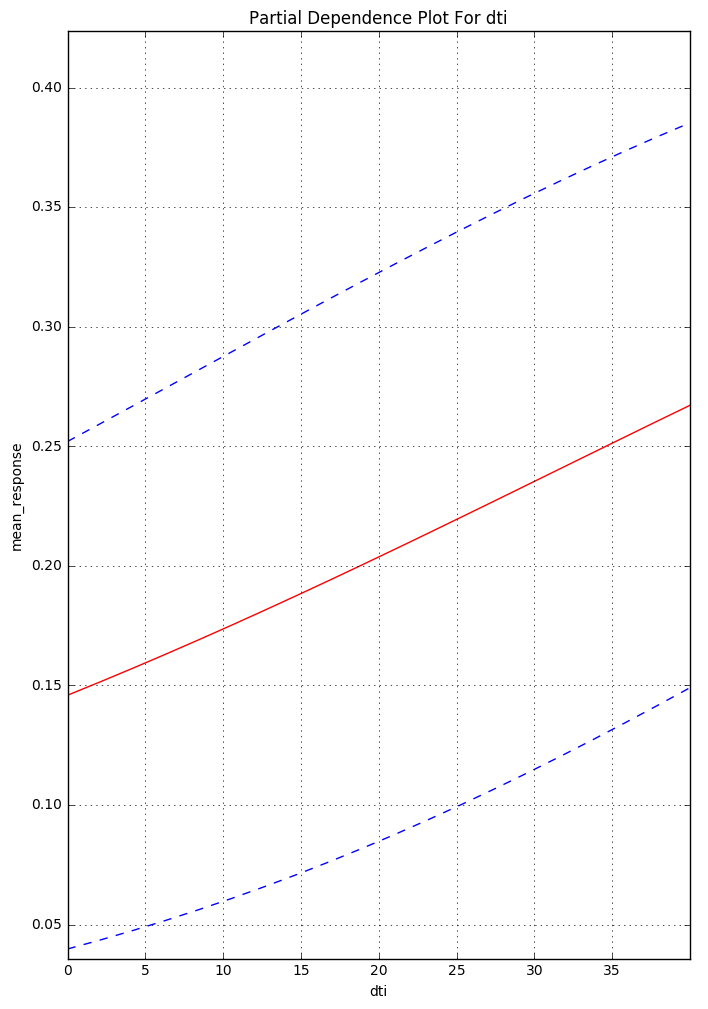

In [18]:
# partial dependence plots are a powerful machine learning interpretation tool
# to calculate partial dependence across the domain a variable
# hold column of interest at constant value
# find the mean prediction of the model with this column constant
# repeat for multiple values of the variable of interest
# h2o has a built-in function for partial dependence as well
par_dep_dti1 = nn_model2.partial_plot(data=train, cols=['dti'], server=True, plot=True)

In [20]:
# shutdown h2o
# be careful ... this can erase your work
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_a1e2 closed.
